In [1]:
import numpy as np
import torch
import torch.nn as nn
import argparse
import os
import random
import time
import hubconf  # noqa: F401
import copy
from quant import (
    block_reconstruction,
    layer_reconstruction,
    BaseQuantBlock,
    QuantModule,
    QuantModel,
    set_weight_quantize_params,
)
from data.imagenet import build_imagenet_data


def seed_all(seed=1029):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=":f"):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = "{name} {val" + self.fmt + "} ({avg" + self.fmt + "})"
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print("\t".join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = "{:" + str(num_digits) + "d}"
        return "[" + fmt + "/" + fmt.format(num_batches) + "]"


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


@torch.no_grad()
def validate_model(val_loader, model, device=None, print_freq=100):
    if device is None:
        device = next(model.parameters()).device
    else:
        model.to(device)
    batch_time = AverageMeter("Time", ":6.3f")
    top1 = AverageMeter("Acc@1", ":6.2f")
    top5 = AverageMeter("Acc@5", ":6.2f")
    inference_speed = AverageMeter("InferenceSpeed (ms)", ":6.3f")
    progress = ProgressMeter(
        len(val_loader), [batch_time, top1, top5, inference_speed], prefix="Test: "
    )

    # switch to evaluate mode
    model.eval()

    # model loading...
    for i, (images, target) in enumerate(val_loader):
        images = images.to(device)
        target = target.to(device)
        output = model(images)
        break

    for i, (images, target) in enumerate(val_loader):
        images = images.to(device)
        target = target.to(device)

        # compute output
        end = time.time()
        output = model(images)

        # measure elapsed time for inference in milliseconds
        inference_time = (time.time() - end) * 1000
        inference_speed.update(inference_time)
        batch_time.update(inference_time)
        end = time.time()

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        if i % print_freq == 0:
            progress.display(i)

    print(
        " * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f} Inference Speed {inference_speed.avg:.3f} ms/batch".format(
            top1=top1, top5=top5, inference_speed=inference_speed
        )
    )

    return top1.avg


def get_train_samples(train_loader, num_samples):
    train_data, target = [], []
    for batch in train_loader:
        train_data.append(batch[0])
        target.append(batch[1])
        if len(train_data) * batch[0].size(0) >= num_samples:
            break
    return (
        torch.cat(train_data, dim=0)[:num_samples],
        torch.cat(target, dim=0)[:num_samples],
    )


parser = argparse.ArgumentParser(
    description="running parameters",
    formatter_class=argparse.ArgumentDefaultsHelpFormatter,
)
# general parameters for data and model
parser.add_argument(
    "--seed", default=1005, type=int, help="random seed for results reproduction"
)
parser.add_argument(
    "--arch",
    default="resnet18",
    type=str,
    help="model name",
    choices=[
        "resnet18",
        "resnet50",
        "mobilenetv2",
        "regnetx_600m",
        "regnetx_3200m",
        "mnasnet",
    ],
)
parser.add_argument(
    "--batch_size", default=64, type=int, help="mini-batch size for data loader"
)
parser.add_argument(
    "--workers", default=4, type=int, help="number of workers for data loader"
)
parser.add_argument(
    "--data_path",
    default="/datasets-to-imagenet",
    type=str,
    help="path to ImageNet data",
)

# quantization parameters
parser.add_argument(
    "--n_bits_w", default=4, type=int, help="bitwidth for weight quantization"
)
parser.add_argument(
    "--channel_wise",
    default=True,
    help="apply channel_wise quantization for weights",
)
parser.add_argument(
    "--n_bits_a", default=4, type=int, help="bitwidth for activation quantization"
)
parser.add_argument("--disable_8bit_head_stem", action="store_true")

# weight calibration parameters
parser.add_argument(
    "--num_samples", default=1024, type=int, help="size of the calibration dataset"
)
parser.add_argument(
    "--iters_w", default=20000, type=int, help="number of iteration for adaround"
)
parser.add_argument(
    "--weight",
    default=0.01,
    type=float,
    help="weight of rounding cost vs the reconstruction loss.",
)
parser.add_argument(
    "--keep_cpu", action="store_true", help="keep the calibration data on cpu"
)

parser.add_argument(
    "--b_start",
    default=20,
    type=int,
    help="temperature at the beginning of calibration",
)
parser.add_argument(
    "--b_end", default=2, type=int, help="temperature at the end of calibration"
)
parser.add_argument(
    "--warmup",
    default=0.2,
    type=float,
    help="in the warmup period no regularization is applied",
)

# activation calibration parameters
parser.add_argument("--lr", default=4e-5, type=float, help="learning rate for LSQ")

parser.add_argument(
    "--init_wmode",
    default="mse",
    type=str,
    choices=["minmax", "mse", "minmax_scale"],
    help="init opt mode for weight",
)
parser.add_argument(
    "--init_amode",
    default="mse",
    type=str,
    choices=["minmax", "mse", "minmax_scale"],
    help="init opt mode for activation",
)

parser.add_argument("--prob", default=0.5, type=float)
parser.add_argument("--input_prob", default=0.5, type=float)
parser.add_argument(
    "--lamb_r", default=0.1, type=float, help="hyper-parameter for regularization"
)
parser.add_argument(
    "--T", default=4.0, type=float, help="temperature coefficient for KL divergence"
)
parser.add_argument(
    "--bn_lr", default=1e-3, type=float, help="learning rate for DC"
)
parser.add_argument(
    "--lamb_c", default=0.02, type=float, help="hyper-parameter for DC"
)
parser.add_argument("--filename", default="tmp", type=str, help="name of pth file")

args = parser.parse_args()

args.seed = 1005
args.arch = "resnet18"
args.batch_size = 64
args.workers = 8
args.data_path = "data/ImageNet"

# Quantization parameters
args.n_bits_w = 4
args.channel_wise = True
args.n_bits_a = 4

# Weight calibration parameters
args.num_samples = 1024
args.iters_w = 20000
args.weight = 0.01

args.b_start = 20
args.b_end = 2
args.warmup = 0.2

# Activation calibration parameters
args.lr = 4e-5

args.init_wmode = "mse"
args.init_amode = "mse"

args.prob = 0.5
args.input_prob = 0.5
args.lamb_r = 0.1
args.T = 4.0
args.bn_lr = 1e-3
args.lamb_c = 0.02

args.filename = "backup/default"  # Filename to save the model / 24.05.29 @jiho264

seed_all(args.seed)
# build imagenet data loader
train_loader, test_loader = build_imagenet_data(
    batch_size=args.batch_size, workers=args.workers, data_path=args.data_path
)
# load model
cnn = eval("hubconf.{}(pretrained=True)".format(args.arch))
cnn.cuda()
cnn.eval()

# print("Full Precision accuracy: {}".format(validate_model(test_loader, cnn)))

fp_model = copy.deepcopy(cnn)
fp_model.cuda()
fp_model.eval()

# build quantization parameters
wq_params = {
    "n_bits": args.n_bits_w,
    "channel_wise": args.channel_wise,
    "scale_method": args.init_wmode,
}
aq_params = {
    "n_bits": args.n_bits_a,
    "channel_wise": False,
    "scale_method": args.init_amode,
    "leaf_param": True,
    "prob": args.prob,
}

fp_model = QuantModel(
    model=fp_model,
    weight_quant_params=wq_params,
    act_quant_params=aq_params,
    is_fusing=False,
)
fp_model.cuda()
fp_model.eval()
fp_model.set_quant_state(False, False)
qnn = QuantModel(
    model=cnn, weight_quant_params=wq_params, act_quant_params=aq_params
)
qnn.cuda()
qnn.eval()
if not args.disable_8bit_head_stem:
    print("Setting the first and the last layer to 8-bit")
    qnn.set_first_last_layer_to_8bit()

qnn.disable_network_output_quantization()
print("the quantized model is below!")
print(qnn)
# cali_data, cali_target = get_train_samples(
#     train_loader, num_samples=args.num_samples
# )
cali_data, cali_target = None, None
device = next(qnn.parameters()).device

# Kwargs for weight rounding calibration
kwargs = dict(
    cali_data=cali_data,
    iters=args.iters_w,
    weight=args.weight,
    b_range=(args.b_start, args.b_end),
    warmup=args.warmup,
    opt_mode="mse",
    lr=args.lr,
    input_prob=args.input_prob,
    keep_gpu=not args.keep_cpu,
    lamb_r=args.lamb_r,
    T=args.T,
    bn_lr=args.bn_lr,
    lamb_c=args.lamb_c,
)

"""init weight quantizer"""
set_weight_quantize_params(qnn)

def set_weight_act_quantize_params(module, fp_module):
    if isinstance(module, QuantModule):
        layer_reconstruction(
            qnn, fp_model, module, fp_module, **kwargs, fromCheckPoint=True
        )
    elif isinstance(module, BaseQuantBlock):
        block_reconstruction(
            qnn, fp_model, module, fp_module, **kwargs, fromCheckPoint=True
        )
    else:
        raise NotImplementedError

def recon_model(model: nn.Module, fp_model: nn.Module):
    """
    Block reconstruction. For the first and last layers, we can only apply layer reconstruction.
    """
    for (name, module), (_, fp_module) in zip(
        model.named_children(), fp_model.named_children()
    ):
        if isinstance(module, QuantModule):
            print("Reconstruction for layer {}".format(name))
            set_weight_act_quantize_params(module, fp_module)
        elif isinstance(module, BaseQuantBlock):
            print("Reconstruction for block {}".format(name))
            set_weight_act_quantize_params(module, fp_module)
        else:
            recon_model(module, fp_module)

# Start calibration
recon_model(qnn, fp_model)

qnn.load_state_dict(
    torch.load(
        # f"logs/W{args.n_bits_w}A{args.n_bits_a}_calib{args.num_samples}_batch{args.batch_size}_iterw{args.iters_w}/{args.arch}/{args.filename}.pth"
        "logs/W4A4_calib1024_batch64_iterW20000/resnet18/backup/default.pth"
    )
)

qnn.set_quant_state(weight_quant=True, act_quant=True)


print(
    "Full quantization (W{}A{}) accuracy: {}".format(
        args.n_bits_w, args.n_bits_a, validate_model(test_loader, qnn)
    )
)

==> Using Pytorch Dataset
Setting the first and the last layer to 8-bit
the quantized model is below!
QuantModel(
  (model): ResNet(
    (conv1): QuantModule(
      wbit=8, abit=4, disable_act_quant=False
      (weight_quantizer): UniformAffineQuantizer(bit=8, is_training=False, inited=True)
      (act_quantizer): UniformAffineQuantizer(bit=4, is_training=False, inited=True)
      (norm_function): StraightThrough()
      (activation_function): ReLU(inplace=True)
    )
    (bn1): StraightThrough()
    (relu): StraightThrough()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): QuantBasicBlock(
        (conv1): QuantModule(
          wbit=4, abit=4, disable_act_quant=False
          (weight_quantizer): UniformAffineQuantizer(bit=4, is_training=False, inited=True)
          (act_quantizer): UniformAffineQuantizer(bit=4, is_training=False, inited=True)
          (norm_function): StraightThrough()
          (activat

In [2]:
def printModuleQuantOnOff(model: nn.Module, fp_model: nn.Module):
    """
    Block reconstruction. For the first and last layers, we can only apply layer reconstruction.
    """
    for (name, module), (_, fp_module) in zip(
        model.named_children(), fp_model.named_children()
    ):

        if isinstance(module, QuantModule):
            print(
                "Reconstruction for layer {}".format(name),
                module.use_weight_quant,
                module.use_act_quant,
            )
        elif isinstance(module, BaseQuantBlock):
            print(
                "Reconstruction for block {}".format(name),
                module.use_weight_quant,
                module.use_act_quant,
            )
        else:
            printModuleQuantOnOff(module, fp_module)


printModuleQuantOnOff(qnn, fp_model)

Reconstruction for layer conv1 True True
Reconstruction for block 0 True True
Reconstruction for block 1 True True
Reconstruction for block 0 True True
Reconstruction for block 1 True True
Reconstruction for block 0 True True
Reconstruction for block 1 True True
Reconstruction for block 0 True True
Reconstruction for block 1 True True
Reconstruction for layer fc True True


In [3]:
cnt = 0
def printModuleName(model: nn.Module, fp_model: nn.Module):
    """
    Block reconstruction. For the first and last layers, we can only apply layer reconstruction.
    """
    for (name, module), (_, fp_module) in zip(
        model.named_children(), fp_model.named_children()
    ):
        if name == "fc":
            print("Quantization disable for layer {}".format(name))
            module.set_quant_state(False, False)
            break
        global cnt
        if isinstance(module, QuantModule):
            print("Reconstruction for layer {}".format(name))
        elif isinstance(module, BaseQuantBlock):
            cnt += 1
            print("Reconstruction for block {}".format(name))
            if cnt == 8:
                module.set_quant_state(False, False)
                print(cnt)
        else:
            printModuleName(module, fp_module)


printModuleName(qnn, fp_model)





printModuleQuantOnOff(qnn, fp_model)

Reconstruction for layer conv1
Reconstruction for block 0
Reconstruction for block 1
Reconstruction for block 0
Reconstruction for block 1
Reconstruction for block 0
Reconstruction for block 1
Reconstruction for block 0
Reconstruction for block 1
8
Quantization disable for layer fc
Reconstruction for layer conv1 True True
Reconstruction for block 0 True True
Reconstruction for block 1 True True
Reconstruction for block 0 True True
Reconstruction for block 1 True True
Reconstruction for block 0 True True
Reconstruction for block 1 True True
Reconstruction for block 0 True True
Reconstruction for block 1 False False
Reconstruction for layer fc False False


In [4]:
print(
    "Full quantization (W{}A{}) accuracy: {}".format(
        args.n_bits_w, args.n_bits_a, validate_model(test_loader, qnn)
    )
)

Test: [  0/782]	Time  6.888 ( 6.888)	Acc@1  87.50 ( 87.50)	Acc@5  93.75 ( 93.75)	InferenceSpeed (ms)  6.888 ( 6.888)
Test: [100/782]	Time  5.240 ( 8.596)	Acc@1  84.38 ( 76.45)	Acc@5  96.88 ( 92.48)	InferenceSpeed (ms)  5.240 ( 8.596)
Test: [200/782]	Time  5.734 ( 8.074)	Acc@1  73.44 ( 75.86)	Acc@5  92.19 ( 93.45)	InferenceSpeed (ms)  5.734 ( 8.074)
Test: [300/782]	Time  5.503 ( 8.003)	Acc@1  78.12 ( 76.10)	Acc@5  96.88 ( 93.49)	InferenceSpeed (ms)  5.503 ( 8.003)
Test: [400/782]	Time  5.570 ( 7.965)	Acc@1  68.75 ( 73.20)	Acc@5  96.88 ( 91.75)	InferenceSpeed (ms)  5.570 ( 7.965)
Test: [500/782]	Time  5.136 ( 8.081)	Acc@1  75.00 ( 71.64)	Acc@5  93.75 ( 90.49)	InferenceSpeed (ms)  5.136 ( 8.081)
Test: [600/782]	Time  5.375 ( 7.994)	Acc@1  81.25 ( 70.53)	Acc@5  89.06 ( 89.65)	InferenceSpeed (ms)  5.375 ( 7.994)
Test: [700/782]	Time  5.584 ( 8.003)	Acc@1  70.31 ( 69.51)	Acc@5  90.62 ( 89.00)	InferenceSpeed (ms)  5.584 ( 8.003)
 * Acc@1 69.418 Acc@5 89.038 Inference Speed 7.898 ms/batch
Full

In [10]:
qnn.set_quant_state(weight_quant=True, act_quant=True)


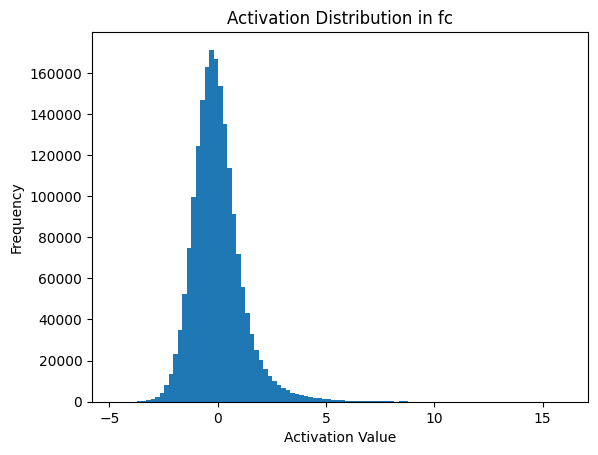

In [11]:
import matplotlib.pyplot as plt
activations = {"layer1": [], "layer2": [], "layer3": [], "layer4": [], "fc": []}
model = qnn
# Forward hook 함수 정의
def get_activation(name):
    def hook(model, input, output):
        activations[name].append(output.detach().cpu())

    return hook

hooks = []
# hooks.append(model.layer4.register_forward_hook(get_activation("layer4")))
hooks.append(model.register_forward_hook(get_activation("fc")))
# 모델을 평가 모드로 전환
model.eval()

# 몇 개의 배치를 통해 활성화 추출
with torch.no_grad():
    for i, (images, labels) in enumerate(train_loader):
        if i >= 10:  # 예시로 100개의 이미지만 사용
            break
        _ = model(images.to("cuda"))

# Hook 제거
for hook in hooks:
    hook.remove()


# 활성화 배열을 하나로 합침 및 히스토그램 그리기 함수
def plot_hist(layer_name, logScale=False):
    all_activations = torch.concatenate(activations[layer_name], axis=0)
    plt.hist(all_activations.flatten(), bins=100)
    plt.title(f"Activation Distribution in {layer_name}")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    if logScale:
        plt.yscale("log")
    plt.show()


# 다른 레이어 활성화 분포 히스토그램 (예시로 layer1)
# plot_hist("layer1", logScale=True)
# plot_hist("layer2", logScale=True)
# plot_hist("layer3", logScale=True)
# plot_hist("layer4", logScale=True)
# FC 레이어 활성화 분포 히스토그램
plot_hist("fc")